# Clustering with Features Selection

In [3]:
!pip install skfeature-chappers

In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA

import math
import statistics

from sklearn.feature_selection import SelectKBest

from skfeature.utility import construct_W  # for affinity matrix for Laplacian representation

## Reading data

In [2]:
with open ("gmw_intersection.json", "r", encoding = "utf-8") as infile:
    gmw_intersection = json.load(infile)

In [3]:
with open("ns_subreddit_2021-01.json", "r", encoding = "utf-8") as infile1:
    ns_subreddit_jan = json.load(infile1)

with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile2:
    ns_subreddit_feb = json.load(infile2)
    
with open("ns_subreddit_2021-03.json", "r", encoding = "utf-8") as infile3:
    ns_subreddit_march = json.load(infile3)

with open("ns_subreddit_2021-04.json", "r", encoding = "utf-8") as infile4:
    ns_subreddit_april = json.load(infile4)
    
with open("ns_subreddit_2021-05.json", "r", encoding = "utf-8") as infile5:
    ns_subreddit_may = json.load(infile5)
    
with open("ns_subreddit_2021-02.json", "r", encoding = "utf-8") as infile6:
    ns_subreddit_jun = json.load(infile6)

In [4]:
# Reading in all the subreddits in our files

with open("subreddit_ns_2021-01.json", "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open("subreddit_ns_2021-03.json", "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open("subreddit_ns_2021-04.json", "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open("subreddit_ns_2021-05.json", "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open("subreddit_ns_2021-02.json", "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

Now, let's set up a fixed ordering for the subreddits as features

In [7]:
subreddit_intersection = list(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [6]:
len(subreddit_intersection)

6220

Let's create the vector representations for each news source, only for news sources that appear in all 6 months.

In [21]:
news_sources_intersection = list(set(ns_subreddit_jan) & set(ns_subreddit_feb) &
      set(ns_subreddit_march) & set(ns_subreddit_april) &
      set(ns_subreddit_may) & set(ns_subreddit_jun))

In [469]:
ns_sr_rep = dict()
for ns in news_sources_intersection: #ns_subreddit_april:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit_april[ns] = Counter(ns_subreddit_april[ns])
    # making sure the ordering follows `subreddit_intersection`
    ns_sr_rep[ns] = [ns_subreddit_april[ns][subreddit_intersection[idx]] for idx in range(len(subreddit_intersection))]

# added Dec 12

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
                               for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
                             for idx in range(len(subreddit_intersection))]   
#     else:
#         ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

Now we normalize the news sources' representations using `numpy`'s normalize.

In [410]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(np.array([[0,20,1000]]).T).T[0]

array([0.  , 0.02, 1.  ])

In [411]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(np.array([[0,20,1000],[1,50,5]]))

array([[0., 0., 1.],
       [1., 1., 0.]])

(Horizontal Normalization)

In [470]:
# ns_sr_rep_normalized = dict()

# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     # ns_sr_rep_normalized[ns] = preprocessing.normalize(np.array([rep]))
#     min_max_scaler = preprocessing.MinMaxScaler()
#     ns_sr_rep_normalized[ns] = min_max_scaler.fit_transform(np.array([rep]).T).T[0]

ns_sr_rep_normalized = ns_sr_rep

In [471]:
len(ns_sr_rep_normalized)

2785

We have 2785 news sources.

In [473]:
list(ns_sr_rep_normalized.items())[0]

('as.com',
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [415]:
"nytimes.com" in ns_sr_rep_normalized.keys()

True

### Features Selection

First I cast the data structure I needed to te appropriate based on the functions I will call.

In [474]:
frozen_nsfeatures = list(ns_sr_rep_normalized.items())

In [475]:
newssources = [k[0] for k in frozen_nsfeatures]

In [476]:
len(newssources)

2785

In [477]:
features = [k[1] for k in frozen_nsfeatures]

In [478]:
len(features)

2785

In [421]:
features[:3]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


#### Normalizing
Vertical normalization.

In [825]:
min_max_scaler = preprocessing.MinMaxScaler()
# features_normalized = min_max_scaler.fit_transform(features)
features_normalized = preprocessing.normalize(features)
# features_normalized = features

Then we select 500 features. Note that we need unsupervised feature selection method. Continue here: https://towardsdatascience.com/overview-of-feature-selection-methods-a2d115c7a8f7.

In [359]:
?construct_W.construct_W

In [835]:
# creating Laplacian matrix representation
# from skfeature.utility import construct_W

kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}

# kwargs_W = {"metric":"cosine","neighbor_mode":"knn","weight_mode":"cosine"} #,"k":5,'t':1}
W = construct_W.construct_W(np.array(features_normalized), **kwargs_W)

In [836]:
# ranking scores
from skfeature.function.similarity_based import lap_score

score = lap_score.lap_score(np.array(features_normalized), W=W, mode="rank")

In [837]:
print(score)

[3190 6012 3213 ... 4381  556 3124]


In [838]:
len(set(score)) == len(score) # subreddits were assigned unique scores

True

In [839]:
len(score) == len(subreddit_intersection)

True

Let's order our subreddits based on their importance in this sense.

In [840]:
# ordered_subreddits_dict = {sc:subreddit_intersection[sc] for sc in score}
ordered_subreddits_dict = {score[idx]:subreddit_intersection[idx] for idx in range(len(score))}

In [841]:
ordered_subreddits = [ordered_subreddits_dict[s] for s in range(len(score))]

In [842]:
for i in range(50):
    print(f"ordered_subreddits[{i}]: {ordered_subreddits[i]}")

ordered_subreddits[0]: Crainn
ordered_subreddits[1]: bag_o_news
ordered_subreddits[2]: chicagohistory
ordered_subreddits[3]: replyallpodcast
ordered_subreddits[4]: ElectricalEngineering
ordered_subreddits[5]: Supplements
ordered_subreddits[6]: Hammers
ordered_subreddits[7]: QuebecLibre
ordered_subreddits[8]: HealthyFood
ordered_subreddits[9]: News_Manufacture
ordered_subreddits[10]: trianglefood
ordered_subreddits[11]: Cinema
ordered_subreddits[12]: DevonUK
ordered_subreddits[13]: Music
ordered_subreddits[14]: data
ordered_subreddits[15]: Muppets
ordered_subreddits[16]: CrusaderKings
ordered_subreddits[17]: tennis
ordered_subreddits[18]: News_Utility
ordered_subreddits[19]: AFL
ordered_subreddits[20]: childfree
ordered_subreddits[21]: LSD
ordered_subreddits[22]: Genshin_Impact
ordered_subreddits[23]: LeavingNeverlandHBO
ordered_subreddits[24]: Eau_Claire
ordered_subreddits[25]: WomenSportsNews
ordered_subreddits[26]: ArsenalWFC
ordered_subreddits[27]: islamabad
ordered_subreddits[28]: 

In [843]:
# Ten most important subreddits
ordered_subreddits[:50]

['Crainn',
 'bag_o_news',
 'chicagohistory',
 'replyallpodcast',
 'ElectricalEngineering',
 'Supplements',
 'Hammers',
 'QuebecLibre',
 'HealthyFood',
 'News_Manufacture',
 'trianglefood',
 'Cinema',
 'DevonUK',
 'Music',
 'data',
 'Muppets',
 'CrusaderKings',
 'tennis',
 'News_Utility',
 'AFL',
 'childfree',
 'LSD',
 'Genshin_Impact',
 'LeavingNeverlandHBO',
 'Eau_Claire',
 'WomenSportsNews',
 'ArsenalWFC',
 'islamabad',
 'MilitaryProcurement',
 'GoldandBlack',
 'shield',
 'PennyStocksDD',
 'SCJerk',
 'arkitektur',
 'roswell',
 'preppers',
 'herbalism',
 'leftist',
 'jacobinmagazine',
 'NunavutPolitics',
 'conservation',
 'TopWatch',
 'topofreddit',
 'FranceDetendue',
 'animegifs',
 'Waikiki',
 'Libernadian',
 'RiskItForTheBiscuits',
 'meToo',
 'uAlberta']

In [432]:
# with open("ordered_subreddits_laplacian.json", "w", encoding="utf-8") as outfile:
#     json.dump(ordered_subreddits, outfile)

In [844]:
# filter to only include the 100 top subreddits
new_features_laplacian = [[row[idx] for idx in range(len(row)) if subreddit_intersection[idx] in ordered_subreddits[:200]] for row in features_normalized]

In [845]:
len(new_features_laplacian[0])

200

## Clustering

For starters, let's try 5 clusters

In [846]:
[(min(k), max(k)) for k in new_features_laplacian]

[(0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.06280742930213278),
 (0.0, 0.004693646099959738),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.01854078591978247),
 (0.0, 0.0),
 (0.0, 0.005890409356147043),
 (0.0, 0.0),
 (0.0, 0.17349447958987207),
 (0.0, 0.06913419199623626),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0890870806374748),
 (0.0, 0.0),
 (0.0, 0.05598925109558543),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.41229219519499),
 (0.0, 0.0),
 (0.0, 0.028287100098921443),
 (0.0, 0.0),
 (0.0, 0.030711348809341347),
 (0.0, 0.004351969732120954),
 (0.0, 0.013143680123941077),
 (0.0, 0.13258252147247765),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.012861802823771822),
 (0.0, 0.09215513551681828),
 (0.0, 0.0),
 (0.0, 0.04106507811765909),
 (0.0, 0.08408277820068158),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.02789913168791248),
 (0.0, 0.011592303873878879),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.04695819060429295),
 (0.0, 0.007333637278154626),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0,

In [847]:
len([k for k in new_features_laplacian if (min(k), max(k)) == (0.0, 0.0)])/len(newssources)

0.49587073608617593

58% of the news sources only have 0's as its features. Let's discard these news sources

In [437]:
not_just_zeroes = [idx for idx in range(len(new_features_laplacian)) if (min(new_features_laplacian[idx]), max(new_features_laplacian[idx])) != (0.0, 0.0)]

In [438]:
len(not_just_zeroes)

1402

In [439]:
new_features_laplacian = [new_features_laplacian[i] for i in not_just_zeroes]

In [440]:
len(new_features_laplacian)

1402

In [441]:
newssources = [newssources[i] for i in not_just_zeroes]
len(newssources)

1402

In [848]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [849]:
kmeans5.fit(new_features_laplacian)

KMeans(init='random', max_iter=100, n_clusters=5)

In [850]:
kmeans5.inertia_

46.453771924451324

In [851]:
kmeans5.n_iter_

6

### Choosing the appropriate number of clusters

In [852]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [853]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features_laplacian)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [57.037202031843414]
have done 2 rounds, current sse is [57.037202031843414, 52.941532300620395]
have done 3 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122]
have done 4 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141]
have done 5 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906]
have done 6 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136]
have done 7 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729]
have done 8 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.36465559588737]
have done 9 r

have done 28 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.36465559588737, 36.400021094911956, 34.06537316034641, 31.598659005423755, 31.26438358980402, 29.978651823910106, 28.924847736640366, 27.547464529690377, 26.835895140531136, 25.5510248476894, 25.3404888013643, 24.236349100472683, 23.167256226270016, 22.372505360395454, 21.849822060122236, 21.57788637861915, 20.468302650531292, 20.182504402180715, 19.42395864374791, 18.707303660012933, 17.99292298366619]
have done 29 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.36465559588737, 36.400021094911956, 34.06537316034641, 31.598659005423755, 31.26438358980402, 29.978651823910106, 28.924847736640366, 27.547464529690377, 26.835895140531136, 25.5510248476894, 25.3404888013643, 24.236349100472683, 23.1672562262

have done 40 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.36465559588737, 36.400021094911956, 34.06537316034641, 31.598659005423755, 31.26438358980402, 29.978651823910106, 28.924847736640366, 27.547464529690377, 26.835895140531136, 25.5510248476894, 25.3404888013643, 24.236349100472683, 23.167256226270016, 22.372505360395454, 21.849822060122236, 21.57788637861915, 20.468302650531292, 20.182504402180715, 19.42395864374791, 18.707303660012933, 17.99292298366619, 18.00438580356311, 17.56876558046745, 16.98489942292509, 16.85827481933088, 15.8895097107597, 15.481153107298397, 15.35769512127803, 15.136653093371027, 14.886675572670722, 14.572648206964079, 14.0569242291792, 13.933430080447199]
have done 41 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.364655595887

have done 50 rounds, current sse is [57.037202031843414, 52.941532300620395, 49.80370144566122, 46.35985971219141, 43.62035179775906, 41.64661884746136, 40.31303187034729, 38.36465559588737, 36.400021094911956, 34.06537316034641, 31.598659005423755, 31.26438358980402, 29.978651823910106, 28.924847736640366, 27.547464529690377, 26.835895140531136, 25.5510248476894, 25.3404888013643, 24.236349100472683, 23.167256226270016, 22.372505360395454, 21.849822060122236, 21.57788637861915, 20.468302650531292, 20.182504402180715, 19.42395864374791, 18.707303660012933, 17.99292298366619, 18.00438580356311, 17.56876558046745, 16.98489942292509, 16.85827481933088, 15.8895097107597, 15.481153107298397, 15.35769512127803, 15.136653093371027, 14.886675572670722, 14.572648206964079, 14.0569242291792, 13.933430080447199, 13.720755227459128, 13.179680445524058, 13.452961513043237, 12.892954706718418, 12.644718418628935, 12.453564127194833, 12.21278052872004, 12.037995178734935, 11.46903792262988, 11.534259

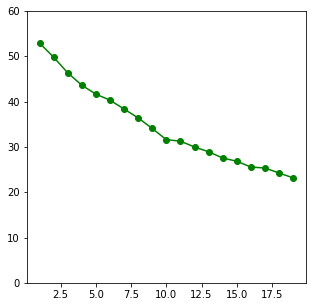

In [885]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,60])
plt.ticklabel_format(style = 'plain')

In [856]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

10

(0.0, 60.0)

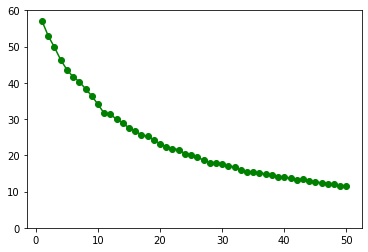

In [858]:
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,60])

In [859]:
kl = KneeLocator(range(1,51), sse[:51], curve="convex", direction="decreasing")
kl.elbow

20

Using Silhouette Coefficient

In [860]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features_laplacian)
    score = silhouette_score(new_features_laplacian, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


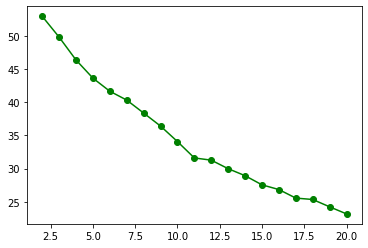

In [863]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [864]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

11

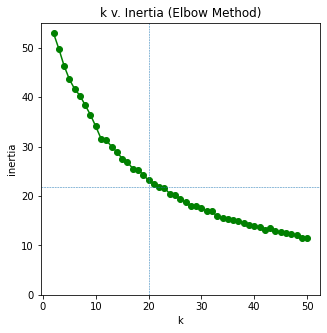

In [886]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51),new_sse,"go-")
plt.ylim([0,55])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=20, linestyle='--', linewidth = 0.5)
plt.axhline(y=new_sse[20], linestyle='--', linewidth = 0.5)

In [884]:
kl_new = KneeLocator(
    range(2,51), 
    new_sse, 
    curve="convex", 
    direction="decreasing")
kl_new.elbow

20

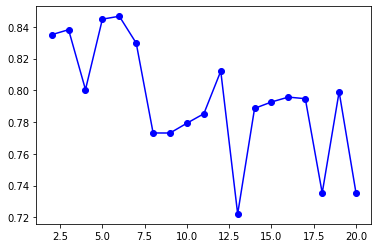

In [865]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

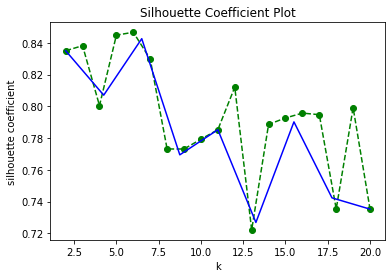

In [866]:


spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 9)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go--")
plt.plot(xs, ys, "b-")
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

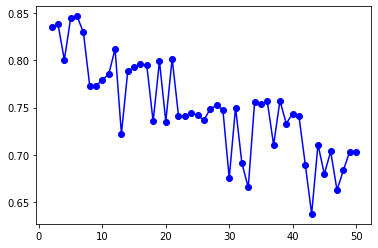

In [867]:
# for silhouette coefficient
plt.plot(range(2,51), sc, "bo-")

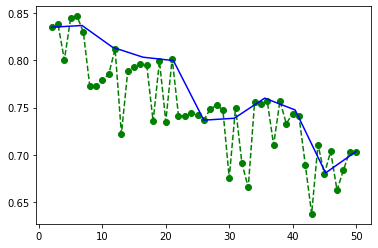

In [868]:


spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 11)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

In [869]:
len(sc)

49

In [873]:
print([k+2 for k in range(len(sc[2:])) if sc[k]==max(sc[2:])])

[6]


Text(0.5, 0, 'k')

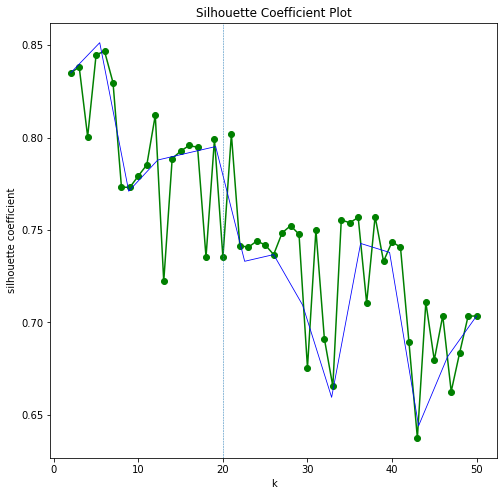

In [893]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 15)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=20, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

Clusters

In [894]:
kmeans = KMeans(n_clusters = 20, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features_laplacian)

KMeans(max_iter=500, n_clusters=20, n_init=50, random_state=56789432)

In [895]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [898]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(20)])

Cluster size (total of 2785)
[2670, 15, 10, 7, 7, 4, 9, 1, 4, 1, 1, 2, 12, 14, 3, 1, 19, 2, 2, 1]


In [899]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])

Proportion in each cluster:
[95.87, 0.54, 0.36, 0.25, 0.25, 0.14, 0.32, 0.04, 0.14, 0.04, 0.04, 0.07]


In [313]:
clustered[6]

['newscientist.com', 'moneysavingexpert.com']

In [88]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[0]


In [518]:
?KMeans

## Low Variance
What about selecting features using `skfeature.function.statistical_based.low_variance`

First let's look at the various variances of the feature columns.

In [480]:
variances = [statistics.pvariance([row[idx] for row in features_normalized]) for idx in range(len(features_normalized[0]))]

In [481]:
len(variances)

6220

In [482]:
max(variances)

0.036082942854536185

Text(0.5, 0, 'variance')

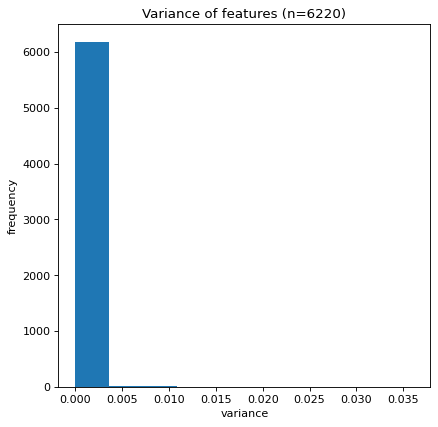

In [483]:
figure(figsize=(6, 6), dpi=80)
plt.hist([v for v in variances])
plt.title("Variance of features (n=6220)")
plt.ylabel("frequency")
plt.xlabel("variance")

In [733]:
?plt.yticks

([<matplotlib.axis.YTick at 0x1f1e49ec910>,
 [Text(0, 0, ''), Text(0, 1, '>0.001'), Text(0, 2, 'all')])

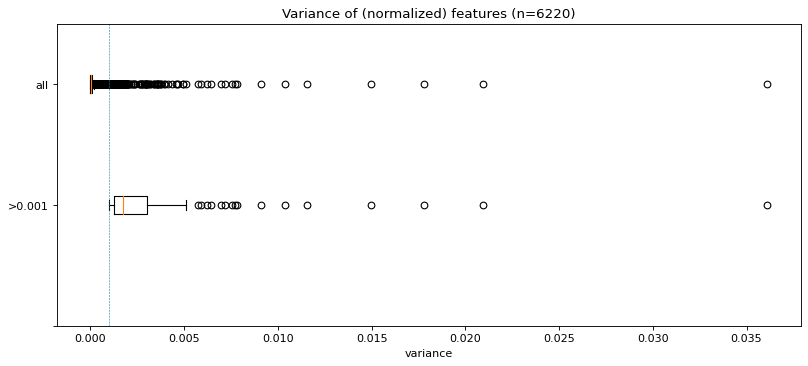

In [741]:
figure(figsize=(12, 5), dpi=80)
# plt.boxplot([v for v in variances], vert=False)
plt.boxplot([[v for v in variances if v > 0.001],[v for v in variances]], vert = False)
plt.axvline(x=0.001, linestyle='--', linewidth = 0.5)
plt.title("Variance of (normalized) features (n=6220)")
# plt.ylabel("frequency")
plt.xlabel("variance")
plt.yticks(np.arange(0, 1))  # Set label locations.
plt.yticks(np.arange(3), ['','>0.001', 'all'])  # Set text labels.
# plt.xlim([0.001,0.038])

In [485]:
from sklearn.feature_selection import VarianceThreshold

In [703]:
# threshold = 0.000075
selector = VarianceThreshold(threshold=0.0009)
new_features = selector.fit_transform(np.array(features_normalized))

In [742]:
len(new_features[0])

206

In [743]:
# ?VarianceThreshold

How many news sources had only 0's as features?

In [744]:
not_just_zeroes = [(newssources[idx], min(new_features[idx]),max(new_features[idx])) for idx in range(len(new_features)) if (min(new_features[idx]),max(new_features[idx])) != (0.0,0.0)]

In [745]:
len(not_just_zeroes)

2726

In [746]:
len(newssources)

2785

## Clustering

For starters, let's try 5 clusters

In [747]:
items = new_features.tolist()

In [748]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [749]:
kmeans5.fit(new_features)

KMeans(init='random', max_iter=100, n_clusters=5)

In [750]:
kmeans5.inertia_

1280.0882602556237

In [751]:
kmeans5.n_iter_

15

### Choosing the appropriate number of clusters

In [752]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [753]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [1485.7148236778946]
have done 2 rounds, current sse is [1485.7148236778946, 1402.2351834941608]
have done 3 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704]
have done 4 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857]
have done 5 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102]
have done 6 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503]
have done 7 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424]
have done 8 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.921722634199]
have

have done 28 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.921722634199, 1187.8053262817111, 1163.5687817753872, 1149.2203800127365, 1134.5322836115595, 1111.3740674775127, 1104.2072894298262, 1085.2024894985718, 1057.1921691504942, 1064.2235764874747, 1033.716812807342, 1024.212166344177, 1017.9660308529133, 990.1493018514543, 997.9154097627705, 972.8416550825737, 979.2695133905252, 962.4650200613573, 947.1030543583407, 936.8677853564304, 921.5683277650146]
have done 29 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.921722634199, 1187.8053262817111, 1163.5687817753872, 1149.2203800127365, 1134.5322836115595, 1111.3740674775127, 1104.2072894298262, 1085.2024894985718, 1057.1921691504942, 1064.2235764874747, 1033.716812807342, 1024.212166344177, 1017

have done 40 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.921722634199, 1187.8053262817111, 1163.5687817753872, 1149.2203800127365, 1134.5322836115595, 1111.3740674775127, 1104.2072894298262, 1085.2024894985718, 1057.1921691504942, 1064.2235764874747, 1033.716812807342, 1024.212166344177, 1017.9660308529133, 990.1493018514543, 997.9154097627705, 972.8416550825737, 979.2695133905252, 962.4650200613573, 947.1030543583407, 936.8677853564304, 921.5683277650146, 926.3949923014798, 910.1179562533379, 890.7314156116823, 901.8449424464665, 895.7803541225067, 889.5605316539524, 873.1119981335622, 866.1126439096425, 865.9310321304197, 842.0076655368465, 844.2193114137518, 824.1815920980109]
have done 41 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.92172263

have done 50 rounds, current sse is [1485.7148236778946, 1402.2351834941608, 1342.134231659704, 1307.617201752857, 1289.6725920555102, 1252.7350908722503, 1234.4965790410424, 1188.921722634199, 1187.8053262817111, 1163.5687817753872, 1149.2203800127365, 1134.5322836115595, 1111.3740674775127, 1104.2072894298262, 1085.2024894985718, 1057.1921691504942, 1064.2235764874747, 1033.716812807342, 1024.212166344177, 1017.9660308529133, 990.1493018514543, 997.9154097627705, 972.8416550825737, 979.2695133905252, 962.4650200613573, 947.1030543583407, 936.8677853564304, 921.5683277650146, 926.3949923014798, 910.1179562533379, 890.7314156116823, 901.8449424464665, 895.7803541225067, 889.5605316539524, 873.1119981335622, 866.1126439096425, 865.9310321304197, 842.0076655368465, 844.2193114137518, 824.1815920980109, 827.3808325651883, 816.5250030791793, 812.2470061024987, 804.4620798798275, 799.5518897313121, 794.342537380926, 785.7180443311786, 777.8427652653561, 768.3677786962212, 771.0699658863217]

(0.0, 1500.0)

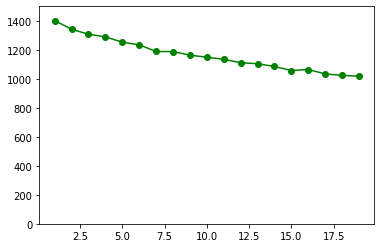

In [756]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1500])

In [757]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

15

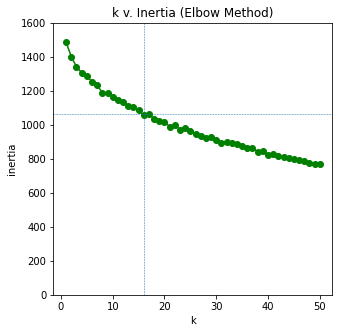

In [783]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1600])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.axhline(y=sse[16], linestyle='--', linewidth = 0.5)

In [782]:
?KneeLocator

In [761]:
kl = KneeLocator(
        range(1,51), 
        sse, curve="convex", 
        direction="decreasing")
kl.elbow

16

Using Silhouette Coefficient

In [762]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


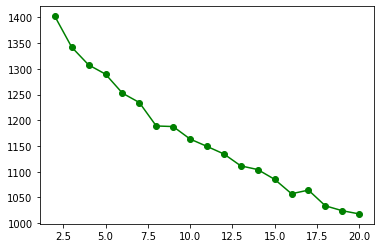

In [763]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [764]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

16

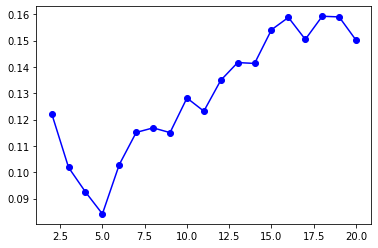

In [765]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

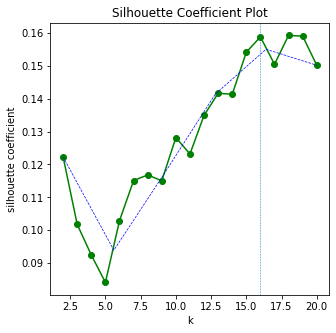

In [784]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go-")
plt.plot(xs, ys, "b--", linewidth=0.7)
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

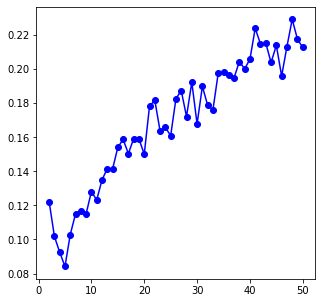

In [785]:
# for silhouette coefficient
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51), sc, "bo-")

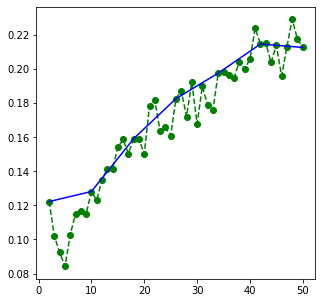

In [786]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

Text(0.5, 0, 'k')

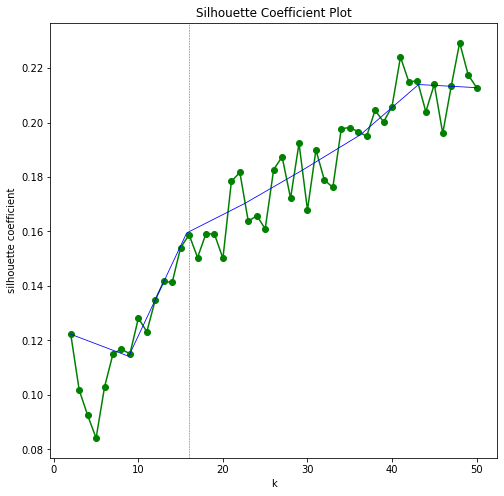

In [795]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 8)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=16, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [790]:
kl = KneeLocator(
        range(3,51), 
        sc[1:], curve="concave", 
        direction="increasing")
kl.elbow

3

In [693]:
len(sc)

49

In [694]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

[35]


Clusters

In [804]:
kmeans = KMeans(n_clusters = 16, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features)

KMeans(max_iter=500, n_clusters=16, n_init=50, random_state=56789432)

In [805]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [806]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(16)])

Cluster size (total of 2785)
[382, 36, 173, 19, 132, 56, 1476, 104, 65, 101, 10, 36, 14, 112, 43, 26]


In [807]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])

Proportion in each cluster:
[13.72, 1.29, 6.21, 0.68, 4.74, 2.01, 53.0, 3.73, 2.33, 3.63, 0.36, 1.29]


In [699]:
len(newssources)-1647

1138

In [824]:
clustered[15]

['am.com.mx',
 'reporteindigo.com',
 'vanguardia.com.mx',
 'diariodequeretaro.com.mx',
 'jornada.com.mx',
 'elsiglodedurango.com.mx',
 'expansion.mx',
 'laverdadnoticias.com',
 'informador.mx',
 'wradio.com.mx',
 'excelsior.com.mx',
 'yucatan.com.mx',
 'sipse.com',
 'cadenanoticias.com',
 'elsoldetulancingo.com.mx',
 'milenio.com',
 'ntrzacatecas.com',
 'proceso.com.mx',
 'elsoldemexico.com.mx',
 'reforma.com',
 'debate.com.mx',
 'radioformula.com.mx',
 'sdpnoticias.com',
 'poresto.net',
 'elheraldodechihuahua.com.mx',
 'elimparcial.com']

Clusters:

0: NPR/NBC affiliated Radio & TV    4: (not sure)                  8:Lifestyle Magazines   12:Argentinian news
1: UK Sport                         5: French news                 9: Mostly (US) TV       13: Other oreign news
2: Some Canadian news (?)           6: (the big cluster)           10: Chilean news        14: German news
3: Brazilian news                   7: Big names, NBC/ABC/PBS TV   11: Italian news        15: Mexican news

In [813]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[7]


In [581]:
?KMeans

## Using Subscribers

In [5]:
# Let's only use the subreddits that have lots of subscribers
with open ("subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [8]:
subreddits_w_subc = [subreddit_intersection[k] for k in range(len(subreddit_intersection)) if subreddit_intersection[k] in subreddit_subscribers]
len(subreddits_w_subc)

5672

In [9]:
len(subreddit_intersection)

6220

Handle missing values

In [10]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

['RedditMobTest', 'LoveForLandlords']


In [11]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

Now, I will sort the 5,672 subreddits based on the # of their subscribers in a descending order.

In [12]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

In [15]:
len(srs_all)

5670

In [14]:
?math.log

Text(0.5, 1.0, 'Subreddits Subscribers (n=5670)')

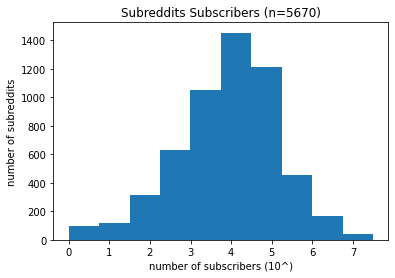

In [16]:
plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])

# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers (n=5670)")
# log scale for both x and y

In [17]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>20000000])

[('funny', 31060166), ('gaming', 26628444), ('aww', 25197817), ('pics', 24911449), ('science', 24268001), ('worldnews', 24253881), ('Music', 24041486), ('videos', 23114010), ('movies', 23087255), ('todayilearned', 23030716), ('news', 20935015), ('IAmA', 20169315)]


In [18]:
srs = srs_all[:200]

In [19]:
"funny" in srs

True

Create news sources representations

In [22]:
ns_sr_rep = dict()
for ns in news_sources_intersection: #ns_subreddit_april:
    # the representation of a news source = # mentions in each subreddit
    ns_subreddit_april[ns] = Counter(ns_subreddit_april[ns])
    # making sure the ordering follows `subreddit_intersection`
    ns_sr_rep[ns] = [ns_subreddit_april[ns][srs[idx]] for idx in range(len(srs))]

# added Dec 12

# january
for ns_jan in ns_subreddit_jan:
    ns_subreddit_jan[ns_jan] = Counter(ns_subreddit_jan[ns_jan])
    if ns_jan in ns_sr_rep:
        # update
        ns_sr_rep[ns_jan] = [ns_sr_rep[ns_jan][idx] + ns_subreddit_jan[ns_jan][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_jan] = [ns_subreddit_jan[ns_jan][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# february
for ns_feb in ns_subreddit_feb:
    ns_subreddit_feb[ns_feb] = Counter(ns_subreddit_feb[ns_feb])
    if ns_feb in ns_sr_rep:
        ns_sr_rep[ns_feb] = [ns_sr_rep[ns_feb][idx] + ns_subreddit_feb[ns_feb][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_feb] = [ns_subreddit_feb[ns_feb][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

# march
for ns_march in ns_subreddit_march:
    ns_subreddit_march[ns_march] = Counter(ns_subreddit_march[ns_march])
    if ns_march in ns_sr_rep:
        ns_sr_rep[ns_march] = [ns_sr_rep[ns_march][idx] + ns_subreddit_march[ns_march][srs[idx]] 
                               for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_march] = [ns_subreddit_march[ns_march][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
     

    
# may
for ns_may in ns_subreddit_may:
    ns_subreddit_may[ns_may] = Counter(ns_subreddit_may[ns_may])
    if ns_may in ns_sr_rep:
        ns_sr_rep[ns_may] = [ns_sr_rep[ns_may][idx] + ns_subreddit_may[ns_may][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_may] = [ns_subreddit_may[ns_may][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]
        
# june
for ns_jun in ns_subreddit_jun:
    ns_subreddit_jun[ns_jun] = Counter(ns_subreddit_jun[ns_jun])
    if ns_jun in ns_sr_rep:
        ns_sr_rep[ns_jun] = [ns_sr_rep[ns_jun][idx] + ns_subreddit_jun[ns_jun][srs[idx]] 
                             for idx in range(len(srs))]   
#     else:
#         ns_sr_rep[ns_jun] = [ns_subreddit_jun[ns_jun][subreddit_intersection[idx]] 
#                              for idx in range(len(subreddit_intersection))]

In [23]:
len(ns_sr_rep['nytimes.com'])

200

In [24]:
len(ns_sr_rep)

2785

Now we normalize the news sources' representations using `numpy`'s normalize.

(Horizontal Normalization)

In [25]:
# ns_sr_rep_normalized = dict()

# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     # ns_sr_rep_normalized[ns] = preprocessing.normalize(np.array([rep]))
#     min_max_scaler = preprocessing.MinMaxScaler()
#     ns_sr_rep_normalized[ns] = min_max_scaler.fit_transform(np.array([rep]).T).T[0]

ns_sr_rep_normalized = ns_sr_rep

In [26]:
len(ns_sr_rep_normalized)

2785

We have 2785 news sources.

In [27]:
list(ns_sr_rep_normalized.items())[0]

('remezcla.com',
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [28]:
"nytimes.com" in ns_sr_rep_normalized.keys()

True

In [29]:
frozen_nsfeatures = list(ns_sr_rep_normalized.items())

In [30]:
newssources = [k[0] for k in frozen_nsfeatures]

In [31]:
len(newssources)

2785

In [32]:
features = [k[1] for k in frozen_nsfeatures]

In [33]:
len(features)

2785

#### Normalizing
Vertical normalization.

In [34]:
min_max_scaler = preprocessing.MinMaxScaler()
# features_normalized = min_max_scaler.fit_transform(features)
features_normalized = preprocessing.normalize(features)
# features_normalized = features

## Clustering

For starters, let's try 5 clusters

In [35]:
kmeans5 = KMeans(init = "random",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

In [37]:
new_features = features_normalized

In [38]:
kmeans5.fit(new_features)

KMeans(init='random', max_iter=100, n_clusters=5)

In [39]:
kmeans5.inertia_

1345.8175257708197

In [40]:
kmeans5.n_iter_

7

### Choosing the appropriate number of clusters

In [41]:
# Elbow method
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 56789432
}

In [42]:
sse = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [1985.0205481994462]
have done 2 rounds, current sse is [1985.0205481994462, 1683.51904869198]
have done 3 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295]
have done 4 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468]
have done 5 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273]
have done 6 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597]
have done 7 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736]
have done 8 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736, 1095.06152788714]
have done 

have done 28 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736, 1095.06152788714, 1050.0956781513175, 998.8280694021569, 974.0454504441826, 927.1928020403994, 912.9992223224674, 889.4963061638879, 863.8764243002698, 841.3753699672322, 834.0846135964686, 816.8202067444553, 793.0263640595243, 785.3951730843727, 771.7830048269166, 762.050717935115, 746.5900520564103, 738.769775526622, 741.730654173076, 721.8395582556684, 707.7340853267291, 703.0871454190794]
have done 29 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736, 1095.06152788714, 1050.0956781513175, 998.8280694021569, 974.0454504441826, 927.1928020403994, 912.9992223224674, 889.4963061638879, 863.8764243002698, 841.3753699672322, 834.0846135964686, 816.8202067444553, 793.0263640595243, 785.3951730843727, 771.78300

have done 41 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736, 1095.06152788714, 1050.0956781513175, 998.8280694021569, 974.0454504441826, 927.1928020403994, 912.9992223224674, 889.4963061638879, 863.8764243002698, 841.3753699672322, 834.0846135964686, 816.8202067444553, 793.0263640595243, 785.3951730843727, 771.7830048269166, 762.050717935115, 746.5900520564103, 738.769775526622, 741.730654173076, 721.8395582556684, 707.7340853267291, 703.0871454190794, 697.5652954014412, 689.5633162627137, 681.3557760225035, 669.3860957570286, 663.2799467908936, 662.3415529070721, 656.7169169951407, 640.394399128755, 642.6192952120554, 634.5721758716668, 632.0143116933483, 621.3064835382388, 618.2186816864513]
have done 42 rounds, current sse is [1985.0205481994462, 1683.51904869198, 1544.5358346162295, 1428.7405153501468, 1326.4951425898273, 1248.4353692147597, 1163.000329936736, 1095.06152

(0.0, 1750.0)

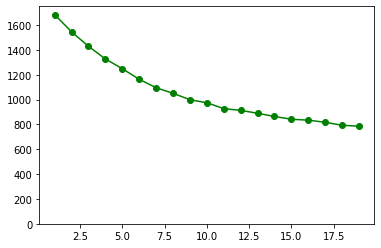

In [45]:
plt.plot(range(1,20),sse[1:20],"go-")
plt.ylim([0,1750])

In [46]:
kl = KneeLocator(range(1,20), sse[1:20], curve="convex", direction="decreasing")
kl.elbow

9

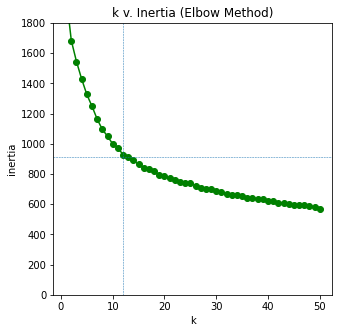

In [51]:
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(1,51),sse,"go-")
plt.ylim([0,1800])
plt.title("k v. Inertia (Elbow Method)")
plt.ylabel("inertia")
plt.xlabel("k")
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.axhline(y=sse[12], linestyle='--', linewidth = 0.5)

In [968]:
?KneeLocator

In [50]:
kl = KneeLocator(
        range(1,51), 
        sse, curve="convex", 
        direction="decreasing")
kl.elbow

12

Using Silhouette Coefficient

In [52]:
sc = []
new_sse = []
for k in range(2,51):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(new_features)
    score = silhouette_score(new_features, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50


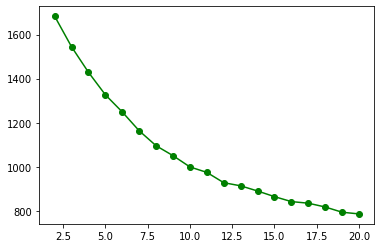

In [53]:
# for sse
plt.plot(range(2,21), new_sse[:19], "go-")

In [54]:
kl_new = KneeLocator(range(2,21), new_sse[:19], curve="convex", direction="decreasing")
kl_new.elbow

10

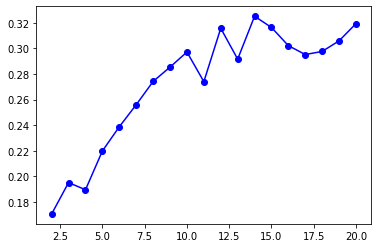

In [55]:
# for silhouette coefficient
plt.plot(range(2,21), sc[:19], "bo-")

Text(0.5, 0, 'k')

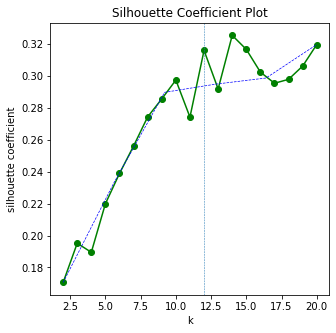

In [57]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,21), sc[:19], k=3)  # type: BSpline

xs = np.linspace(2, 20, 6)
ys = spl(xs)

plt.plot(range(2,21), sc[:19], "go-")
plt.plot(xs, ys, "b--", linewidth=0.7)
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

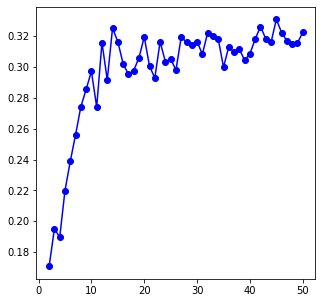

In [58]:
# for silhouette coefficient
figure(figsize=(5, 5)) #, dpi=80)
plt.plot(range(2,51), sc, "bo-")

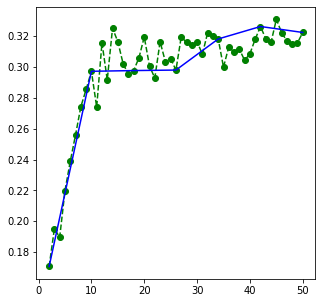

In [59]:

figure(figsize=(5, 5)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 7)
ys = spl(xs)

plt.plot(range(2,51), sc, "go--")
plt.plot(xs, ys, "b-")

Text(0.5, 0, 'k')

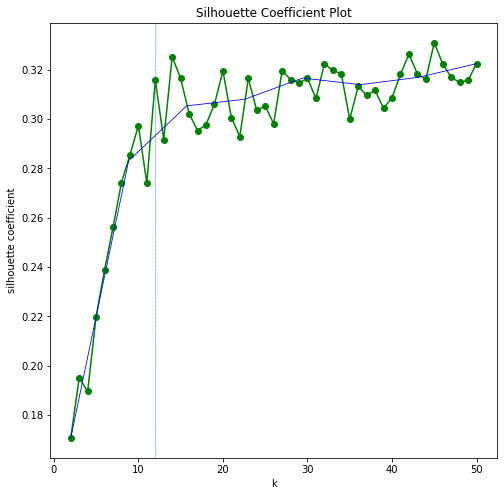

In [61]:
figure(figsize=(8, 8)) #, dpi=80)
spl = make_interp_spline(range(2,51), sc, k=3)  # type: BSpline

xs = np.linspace(2, 50, 8)
ys = spl(xs)

plt.plot(range(2,51), sc, "go-")
plt.plot(xs, ys, "b-", linewidth=0.8)
plt.axvline(x=12, linestyle='--', linewidth = 0.5)
plt.title("Silhouette Coefficient Plot")
plt.ylabel("silhouette coefficient")
plt.xlabel("k")

In [62]:
kl = KneeLocator(
        range(3,51), 
        sc[1:], curve="concave", 
        direction="increasing")
kl.elbow

3

In [63]:
len(sc)

49

In [64]:
print([k for k in range(len(sc)) if sc[k]==max(sc)])

[43]


Clusters

In [65]:
kmeans = KMeans(n_clusters = 12, init="k-means++", n_init = 50, max_iter = 500, random_state = 56789432)
kmeans.fit(new_features)

KMeans(max_iter=500, n_clusters=12, n_init=50, random_state=56789432)

In [66]:
clustered = defaultdict(list)
for idx,ns in enumerate(newssources):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [70]:
print(f"Cluster size (total of {len(newssources)})")
print([len(clustered[i]) for i in range(12)])
print(f"sum: {sum([len(clustered[i]) for i in range(12)])}")

Cluster size (total of 2785)
[421, 133, 156, 839, 340, 44, 85, 134, 233, 183, 136, 81]
sum: 2785


In [72]:
print("Proportion in each cluster:")
print([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])
print(f"sum: {sum([round(len(clustered[i])*100/len(newssources),2) for i in range(12)])}")

Proportion in each cluster:
[15.12, 4.78, 5.6, 30.13, 12.21, 1.58, 3.05, 4.81, 8.37, 6.57, 4.88, 2.91]
sum: 100.00999999999999


In [699]:
len(newssources)-1647

1138

In [76]:
clustered[3]

['warringtonguardian.co.uk',
 'asm.org',
 'poconorecord.com',
 'fijivillage.com',
 'flickeringmyth.com',
 'pastemagazine.com',
 'theaggie.org',
 'campaignlive.co.uk',
 'chabad.org',
 'tbs.co.jp',
 'bz-berlin.de',
 'post-journal.com',
 'alligator.org',
 'omroepbrabant.nl',
 'france.tv',
 'telemundopr.com',
 'tu.no',
 'gsmarena.com',
 'eldoce.tv',
 'nationen.no',
 'abcnyheter.no',
 'premierguitar.com',
 'americanrifleman.org',
 'hollywoodreporter.com',
 'meadvilletribune.com',
 'mmorpg.com',
 'insidelacrosse.com',
 'screencrush.com',
 'greenhousecanada.com',
 'digi.no',
 'hltv.org',
 'monde-diplomatique.fr',
 'autoexpress.co.uk',
 'wbgo.org',
 'onlineathens.com',
 'publishersweekly.com',
 'dna.fr',
 'antaranews.com',
 'fox.com',
 'etc.se',
 'deadline.com',
 'familyhandyman.com',
 'computerworld.com',
 'kbb.com',
 'hodinkee.com',
 'metalinjection.net',
 'bet.com',
 'mubi.com',
 'tucsonweekly.com',
 '01net.com',
 'northcoastjournal.com',
 'newleftreview.org',
 'delano.lu',
 'ahaber.com.tr'

Clusters:

0: NPR/NBC affiliated Radio & TV    4: (not sure)                  8:Lifestyle Magazines   12:Argentinian news
1: UK Sport                         5: French news                 9: Mostly (US) TV       13: Other oreign news
2: Some Canadian news (?)           6: (the big cluster)           10: Chilean news        14: German news
3: Brazilian news                   7: Big names, NBC/ABC/PBS TV   11: Italian news        15: Mexican news

In [813]:
print([k for k in range(25) if "foxnews.com" in clustered[k]])

[7]


In [77]:
clustered_new = dict()
for ii in range(12):
    clustered_new[ii] = clustered[ii]

In [78]:
with open("clusters_subscribers.json", "w", encoding = "utf-8") as outfile:
    json.dump(clustered_new, outfile, indent = 4)